## Symplectic integration of a dumbell system

We consider two point particles of mass $m$ in $\mathbb{R}^3$, connected by:

- a) **harmonic** spring:
  
  $V(r_1, r_2) = \frac{1}{2}k \|r_1 - r_2\|^2$
- b) **anharmonic** spring:
  
    $V(r_1, r_2) = -\frac{\epsilon}{2} \log\left(1 - \frac{\|r_1 - r_2\|^2}{a^2}\right)$

Initial conditions:

\begin{align*}
r_1(0) &= -r_2(0) = \left(\frac{a}{3}, 0, 0\right) \\
p_1(0) &= -p_2(0) = \left(-\frac{6}{7}, \frac{3}{7}, -\frac{2}{7}\right) \sqrt{m\epsilon}
\end{align*}

Units:
- Length: $a$
- Time: $\omega_0^{-1} = \sqrt{m/k}$
- Energy: $\epsilon = ka^2$

### functions level import for plotting

In [1]:
from utils.plotting import plot_trajectory, plot_deviations, plot_angular_direction_deviation, plot_energy_deviation_comparison, plot_scaled_energy

### a) Simulate reference trajectories, momentum, angular momentum and energy conservation for an harmonic spring

Integrating: 100%|██████████████████████████| 250/250 [00:00<00:00, 7538.72it/s]


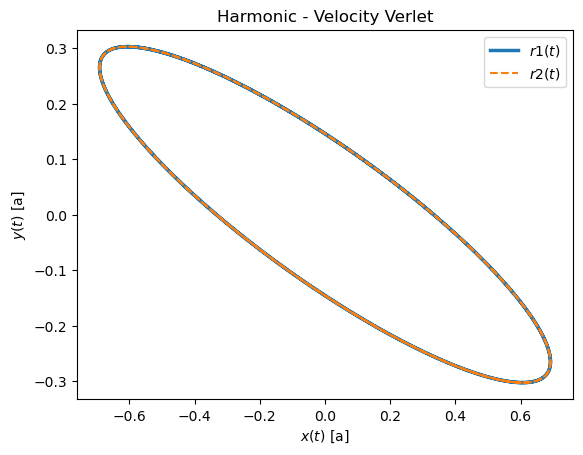

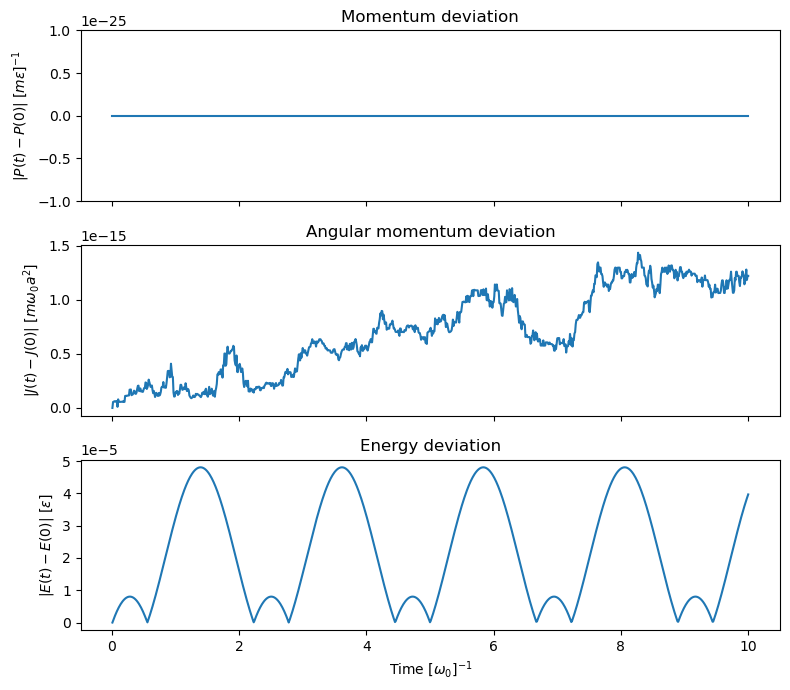

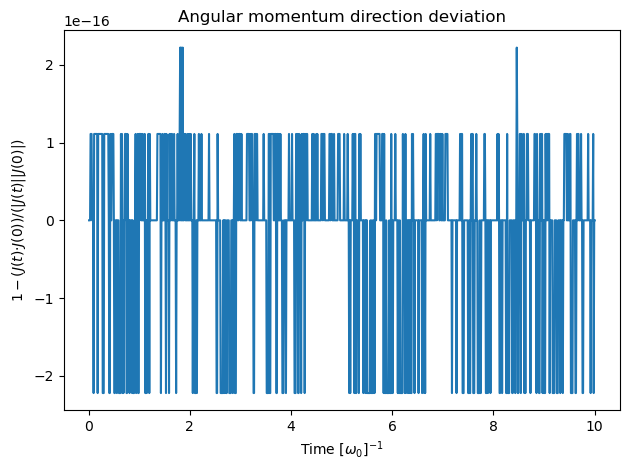

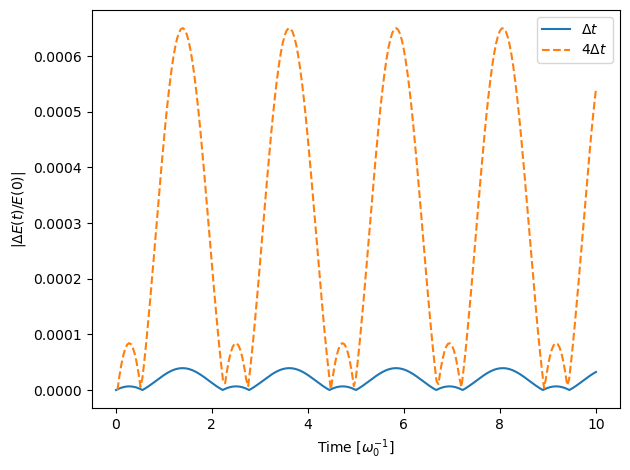

In [2]:
from integrators.velocity_verlet import velocity_verlet_simulation
res_a = velocity_verlet_simulation(N=2, dt=0.01, t_sim=10.0, k=1.0, m=1.0, beta=1.0, 
                                config="linear", random_momenta=False, 
                                return_energy=True, track_observables=True, 
                                seed=None, potential_type="harmonic")


# Simulation with larger timestep (4x)
res_a_4dt = velocity_verlet_simulation(N=2, dt=4*0.01, t_sim=10.0, k=1.0, m=1.0, beta=1.0, 
                                config="linear", random_momenta=False, 
                                return_energy=True, track_observables=True, 
                                seed=None, potential_type="harmonic")


# Plotting (assuming functions take the same result dict format)
plot_trajectory(res_a, title="Harmonic - Velocity Verlet")
plot_deviations(res_a)
plot_angular_direction_deviation(res_a)
plot_energy_deviation_comparison(res_a, res_a_4dt)

### b) Simulate reference trajectories, momentum, angular momentum and energy conservation for an anharmonic spring

Integrating: 100%|██████████████████████████| 250/250 [00:00<00:00, 8576.61it/s]


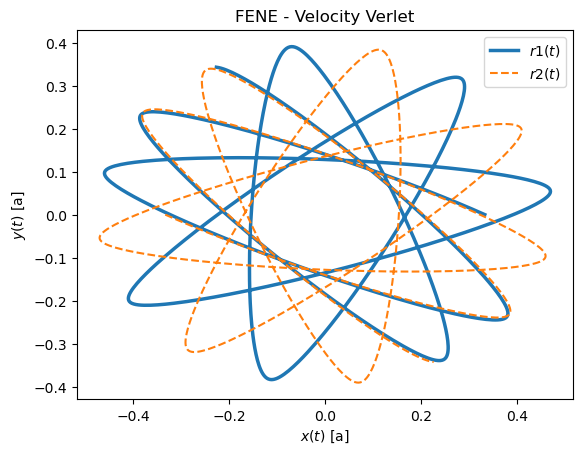

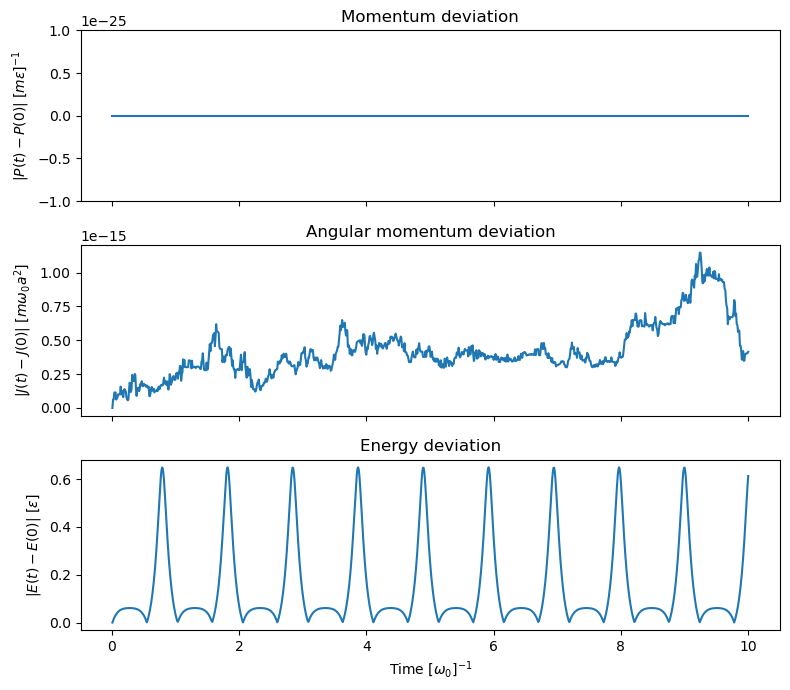

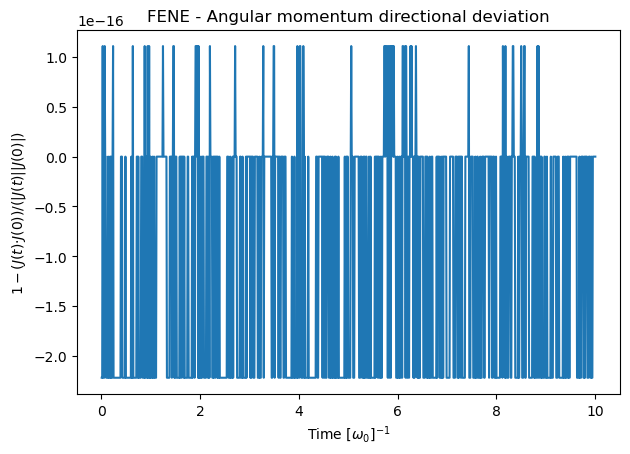

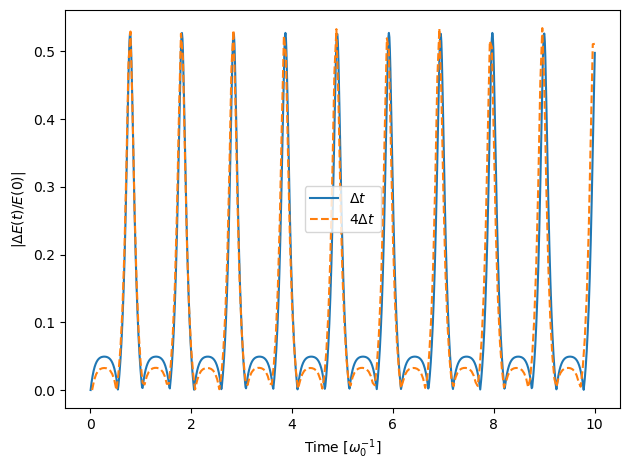

In [3]:
# Simulate for dt and 4dt with FENE potential
res_b = velocity_verlet_simulation(N=2, dt=0.01, t_sim=10.0, k=1.0, m=1.0, beta=1.0, 
                                config="linear", random_momenta=False, 
                                return_energy=True, track_observables=True, 
                                seed=None, potential_type="fene")


# Simulation with larger timestep (4x)
res_b_4dt = velocity_verlet_simulation(N=2, dt=4*0.01, t_sim=10.0, k=1.0, m=1.0, beta=1.0, 
                                config="linear", random_momenta=False, 
                                return_energy=True, track_observables=True, 
                                seed=None, potential_type="fene")


plot_trajectory(res_b, title="FENE - Velocity Verlet")
plot_deviations(res_b)
plot_angular_direction_deviation(res_b, title="FENE - Angular momentum directional deviation")

# Compare energy deviation at dt and 4dt
plot_energy_deviation_comparison(res_b, res_b_4dt)


### c) 5-stage symplectic integrator:

$
e^{iL_{BABAB}\Delta t} = e^{iL_p \lambda \Delta t} e^{iL_x \frac{\Delta t}{2}} e^{iL_p (1 - 2\lambda) \Delta t} e^{iL_x \frac{\Delta t}{2}} e^{iL_p \lambda \Delta t}$

with

$\lambda = \frac{1}{2\left( (2 \sqrt{326} + 36)^{1/3} + \frac{1}{6 (2 \sqrt{326} + 36)^{1/3}} \right)} \approx 0.19$, minimizing energy drift 

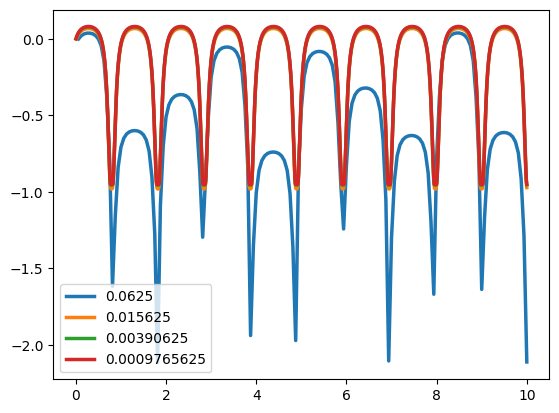

In [22]:
from integrators.omelyan_5stage import simulate_5stage
from utils.plotting import plot_trajectory, plot_deviations, plot_angular_direction_deviation, plot_energy_deviation_comparison, plot_scaled_energy
import matplotlib.pyplot as plt

omega_0_inv = 1.0
dts = [4**(-i) * omega_0_inv for i in range(1, 6)]
orders = [1, 2, 3, 4]

for potential in ["fene"]:
    energy_data = {}
    
    dts_filtered = dts if potential == 'harmonic' else dts[1:]  # removing larger timestep in the case of anharmonic potential
    for dt in dts_filtered:
        res = simulate_5stage(dt=dt, potential_type=potential)
        energy_data[dt] = (res["time"][1:], res["E_traj"])
        plt.plot(res["time"][1:], (res["E_traj"]-res["E_traj"][0])/dt**2, linewidth=2.5, label=dt)
        #plt.plot(res["time"][1:], res["E_traj"], linewidth=2.5, label=dt)
    plt.legend()
    plt.show()     

    #plot_scaled_energy(dts, energy_data, orders, title=f"5-Stage: {potential.title()} potential")

<Figure size 800x400 with 0 Axes>

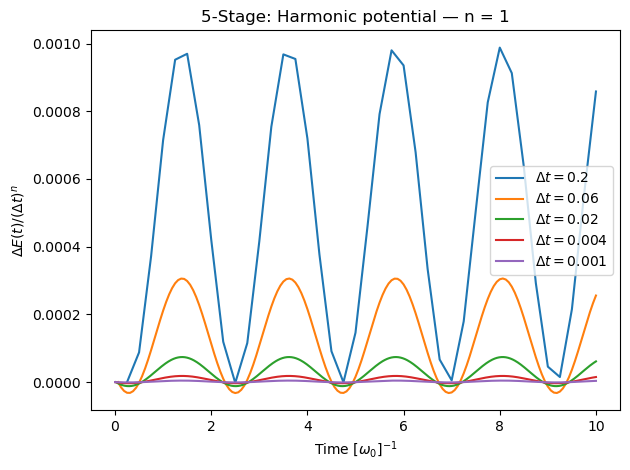

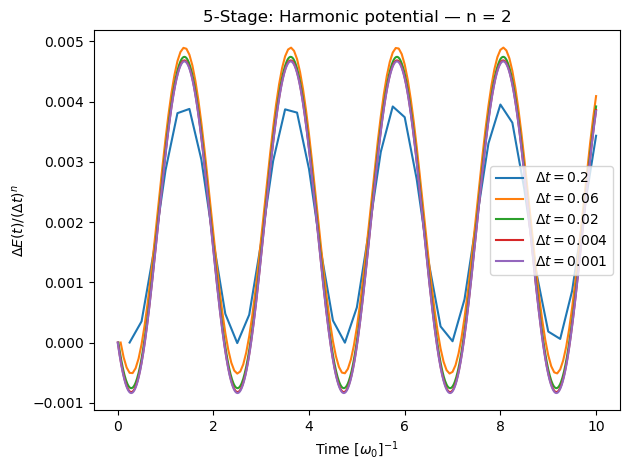

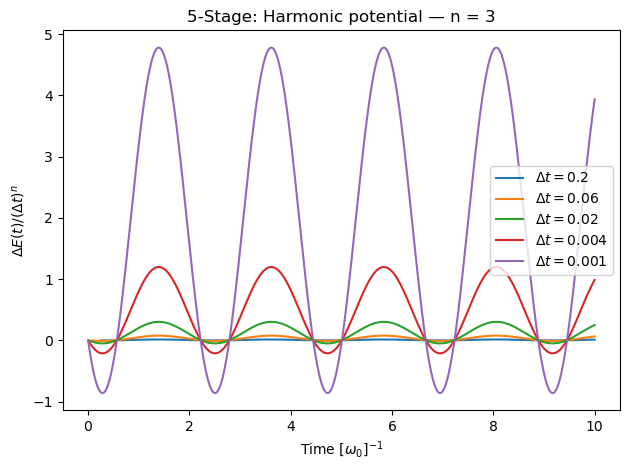

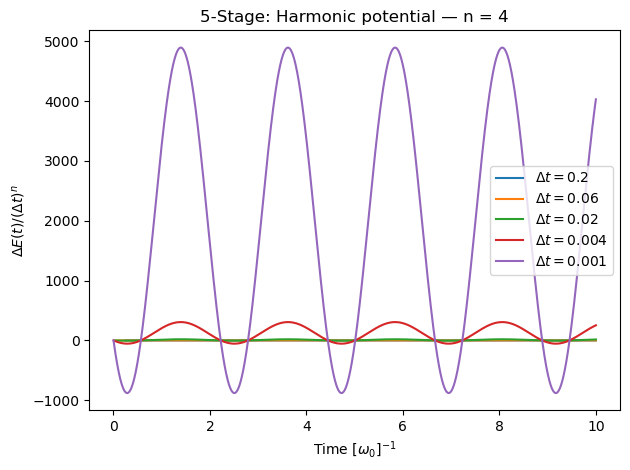

<Figure size 800x400 with 0 Axes>

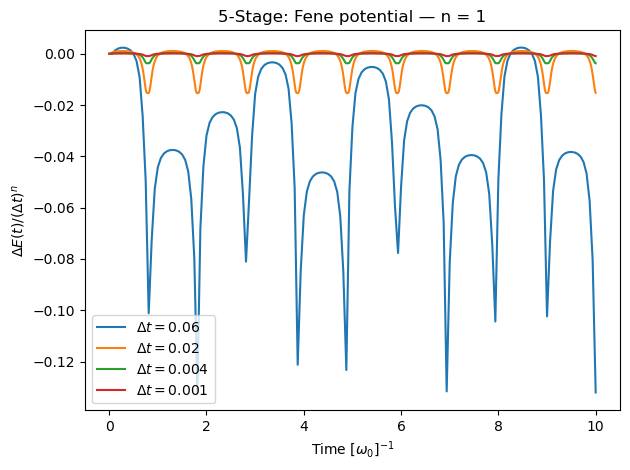

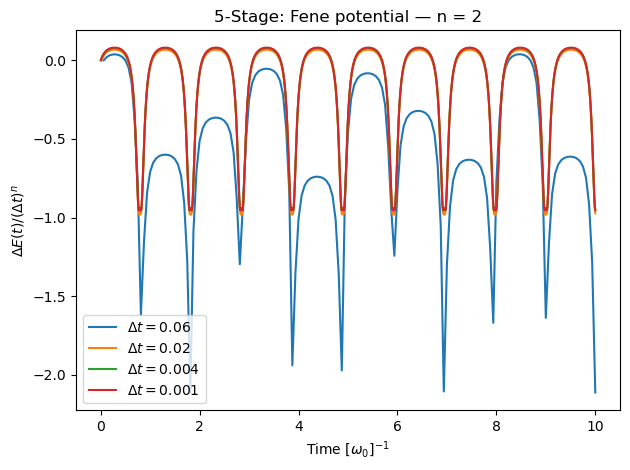

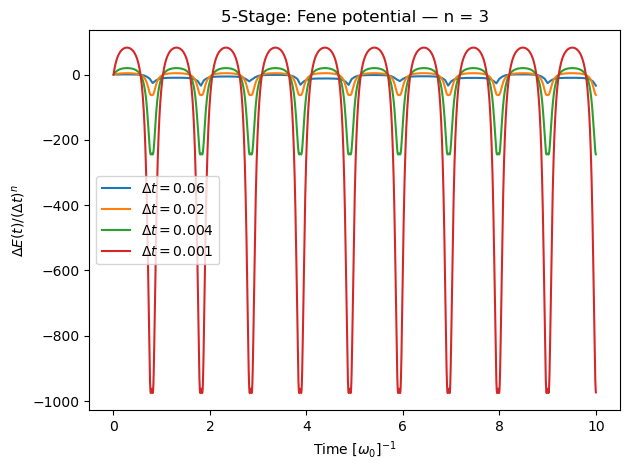

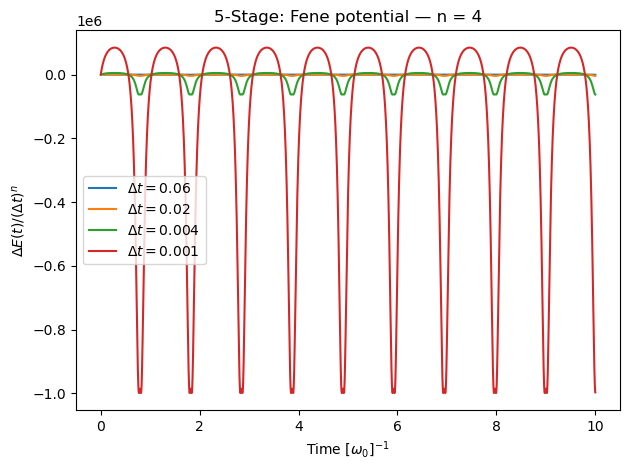

In [4]:
from integrators.omelyan_5stage import simulate_5stage

omega_0_inv = 1.0
dts = [4**(-i) * omega_0_inv for i in range(1, 6)]
orders = [1, 2, 3, 4]

for potential in ["harmonic", "fene"]:
    energy_data = {}
    
    dts_filtered = dts if potential == 'harmonic' else dts[1:]  # removing larger timestep in the case of anharmonic potential
    for dt in dts_filtered:
        res = simulate_5stage(dt=dt, potential_type=potential)
        energy_data[dt] = (res["time"], res["E_traj"])

    plot_scaled_energy(dts, energy_data, orders, title=f"5-Stage: {potential.title()} potential")

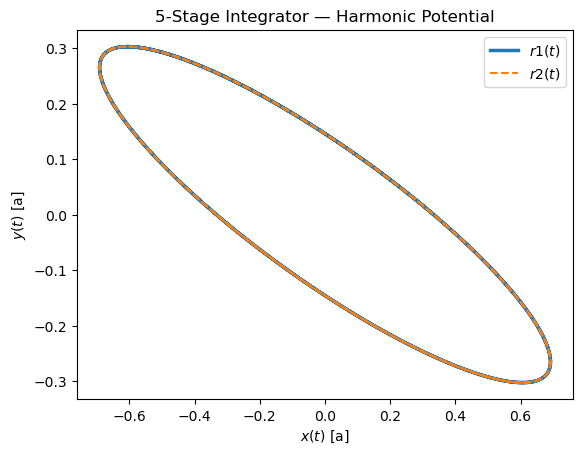

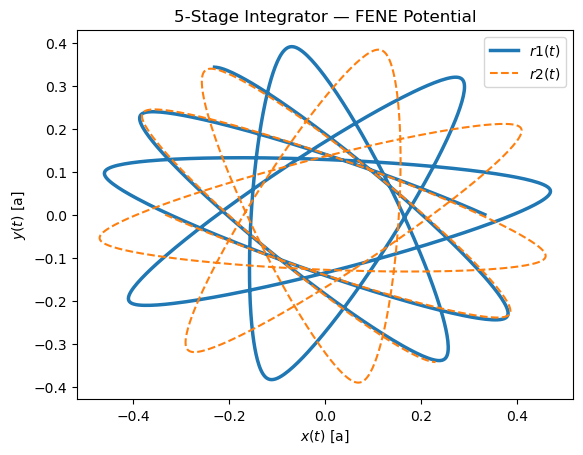

In [5]:
## Plot trajectories too - with dt=0.01 as a-b) points:

# Harmonic potential
res_harmonic_5 = simulate_5stage(dt=0.01, potential_type="harmonic")
plot_trajectory(res_harmonic_5, title="5-Stage Integrator — Harmonic Potential")

# FENE potential
res_fene_5 = simulate_5stage(dt=0.01, potential_type="fene")
plot_trajectory(res_fene_5, title="5-Stage Integrator — FENE Potential")


In [6]:
## TODO: Comparison for different lambdas

#### Comments:
- If the plot for a given $n$ is approximately **flat**, it indicates:

  $\Delta E \propto (\Delta t)^n$


- For the **5-stage integrator**, we observe that:
  
  $\Delta E \sim \mathcal{O}((\Delta t)^2)$

  showing **2nd-order accuracy** in energy conservation.

The parameter $\lambda$ in the 5-stage method determines how the force applications are distributed symmetrically in time.

- **Optimal value**:  

  $ \lambda \approx 0.193183$

  (Derived by Omelyan et al. to minimize energy error.)

- **Other test cases**:
  - $\lambda = \frac{1}{3} $: Still symplectic and stable, but energy error is worse.
  - $\lambda = 0, \frac{1}{2}$: Reduces to a 2-stage method.
Measure **maximum relative energy deviation**:
$ \max_t \left| \frac{\Delta E(t)}{E(0)} \right|$



### d) 11-stage symplectic integrator

In [15]:
from integrators.velocity_verlet import velocity_verlet_simulation_pbc
#from utils.plotting import plot_trajectory, plot_deviations, plot_angular_direction_deviation, plot_energy_deviation_comparison, plot_scaled_energy
import matplotlib.pyplot as plt
def plot_scaled_energy(dts, energy_data, orders, title="Energy scaling"):
    plt.figure(figsize=(8, 4))
    for n in orders:
        plt.figure()
        for dt, (time, energy) in energy_data.items():
            delta_E = energy - energy[0]
            scaled = delta_E / dt**n
            plt.plot(time, scaled, label=f"$\Delta t = {dt:.1}$")
        plt.title(f"{title} — n = {n}")
        plt.xlabel("Time $[\omega_0]^{-1}$")
        plt.ylabel(f"$\Delta E(t) / (\Delta t)^{{n}}$")
        plt.legend()
        plt.tight_layout()
        plt.show()

omega_0_inv = 1.0
dts = [0.001*(2**(i)) * omega_0_inv for i in range(0, 4)]
#dts = [0.001]
#print(dts)

orders = [1, 2, 3, 4]

#for potential in ["harmonic", "fene"]:
energy_data = {}

dts_filtered = dts #if potential == 'harmonic' else dts[1:]  # removing larger timestep in the case of anharmonic potential
for dt in dts_filtered:
    #res = simulate_11stage(dt=dt, potential_type=potential)
    res = velocity_verlet_simulation_pbc(128, dt, 10, 1.,1.,1.,"linear", True, True, None, 6.8399037867, True, False)
    energy_data[dt] = (res["time"], res["E_traj"])
    print(res["time"])
    print(res["E_traj"])

plot_scaled_energy(dts, energy_data, orders, title=f"Velocity verlet: Yukawa potential")

<>:11: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\o'
<>:14: SyntaxWarning: invalid escape sequence '\D'
<>:11: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\o'
<>:14: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Andres\AppData\Local\Temp\ipykernel_27572\2563071145.py:11: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(time, scaled, label=f"$\Delta t = {dt:.1}$")
C:\Users\Andres\AppData\Local\Temp\ipykernel_27572\2563071145.py:13: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("Time $[\omega_0]^{-1}$")
C:\Users\Andres\AppData\Local\Temp\ipykernel_27572\2563071145.py:14: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel(f"$\Delta E(t) / (\Delta t)^{{n}}$")
Integrating: 100%|██████████| 10000/10000 [00:21<00:00, 468.50it/s]


[1.000e-03 2.000e-03 3.000e-03 ... 9.998e+00 9.999e+00 1.000e+01]
[nan nan nan ... nan nan nan]


Integrating:  74%|███████▍  | 3723/5000 [00:07<00:02, 467.28it/s]
C:\Users\Andres\AppData\Local\Temp\ipykernel_27572\2563071145.py:11: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(time, scaled, label=f"$\Delta t = {dt:.1}$")
C:\Users\Andres\AppData\Local\Temp\ipykernel_27572\2563071145.py:13: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("Time $[\omega_0]^{-1}$")
C:\Users\Andres\AppData\Local\Temp\ipykernel_27572\2563071145.py:14: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel(f"$\Delta E(t) / (\Delta t)^{{n}}$")


KeyboardInterrupt: 

c:\descargas\molSimul\Solutions\utils\plotting.py:29: SyntaxWarning: invalid escape sequence '\e'
  axs[0].set_ylabel('$|P(t)-P(0)|$ $[m \epsilon]^{-1}$')
c:\descargas\molSimul\Solutions\utils\plotting.py:35: SyntaxWarning: invalid escape sequence '\o'
  axs[1].set_ylabel('$|J(t)-J(0)|$ $[m \omega_0 a^2]$')
c:\descargas\molSimul\Solutions\utils\plotting.py:39: SyntaxWarning: invalid escape sequence '\e'
  axs[2].set_ylabel('$|E(t)-E(0)|$ $[\epsilon]$')
c:\descargas\molSimul\Solutions\utils\plotting.py:40: SyntaxWarning: invalid escape sequence '\o'
  axs[2].set_xlabel("Time $[\omega_0]^{-1}$")
c:\descargas\molSimul\Solutions\utils\plotting.py:57: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('Time $[\omega_0]^{-1}$')
c:\descargas\molSimul\Solutions\utils\plotting.py:71: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("Time $[\omega_0^{-1}]$")
c:\descargas\molSimul\Solutions\utils\plotting.py:72: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$|\Delta E(t)

ValueError: x and y must have same first dimension, but have shapes (161,) and (160,)

<Figure size 800x400 with 0 Axes>

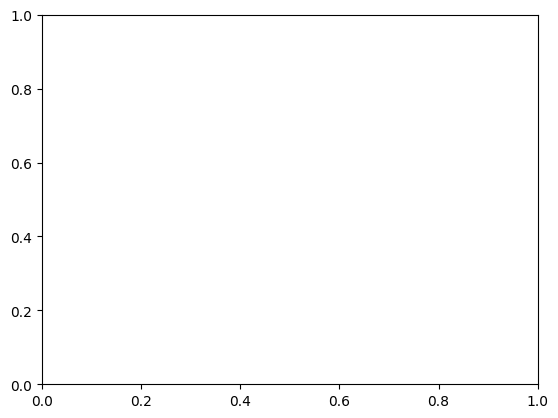

In [1]:
from integrators.omelyan_11stage import simulate_11stage
from utils.plotting import plot_trajectory, plot_deviations, plot_angular_direction_deviation, plot_energy_deviation_comparison, plot_scaled_energy
from integrators.velocity_verlet import velocity_verlet_simulation
from integrators.omelyan_5stage import simulate_5stage
import integrators

import importlib
importlib.reload(integrators)


omega_0_inv = 1.0
dts = [4**(-i) * omega_0_inv for i in range(1, 5)]
orders = [1, 2, 3, 4]

for potential in ["yukawa"]:
    energy_data = {}
    
    dts_filtered = dts if potential == 'harmonic' else dts[1:]  # removing larger timestep in the case of anharmonic potential
    for dt in dts_filtered:
        res = simulate_5stage(dt=dt, potential_type=potential)
        energy_data[dt] = (res["time"], res["E_traj"])

    plot_scaled_energy(dts, energy_data, orders, title=f"5-Stage: {potential.title()} potential")

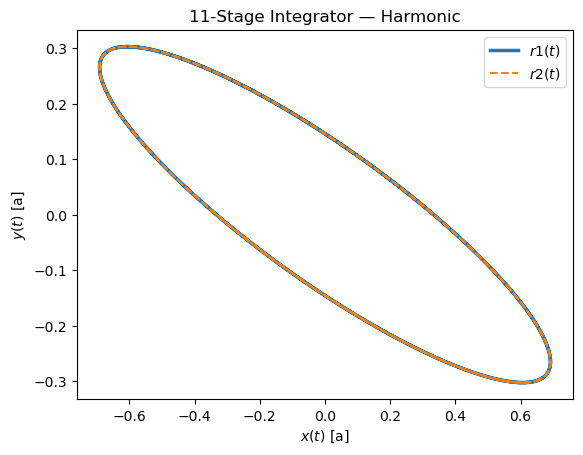

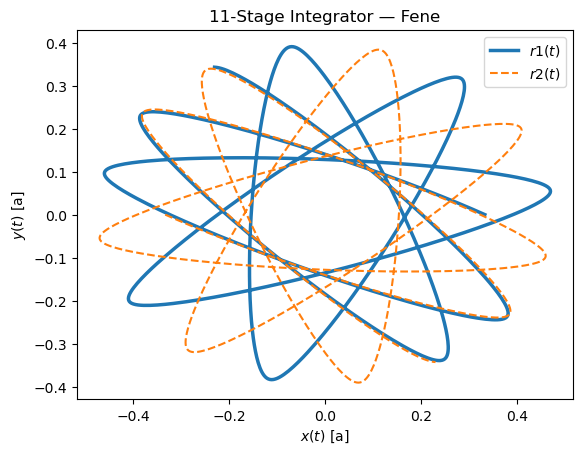

<Figure size 800x400 with 0 Axes>

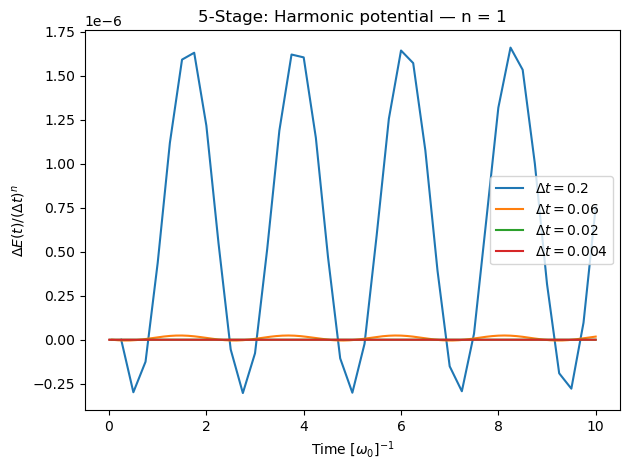

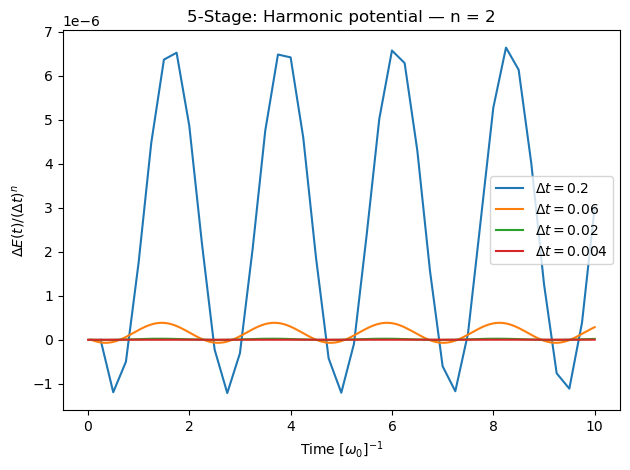

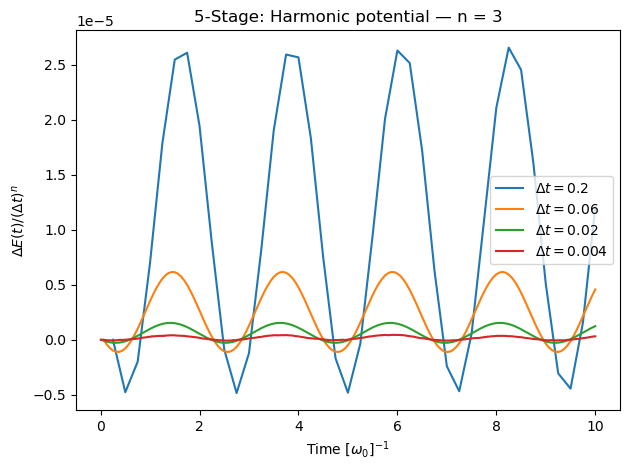

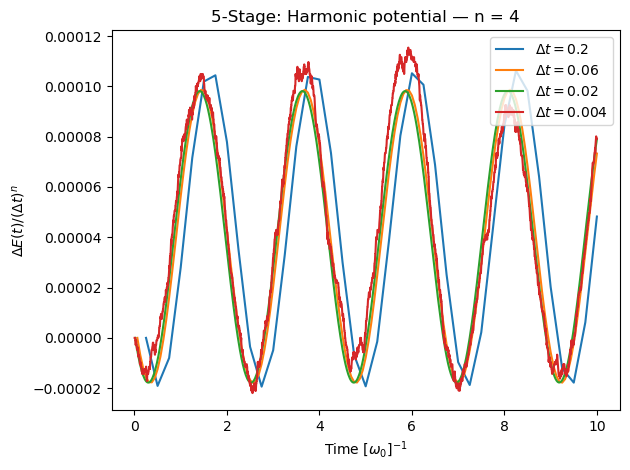

<Figure size 800x400 with 0 Axes>

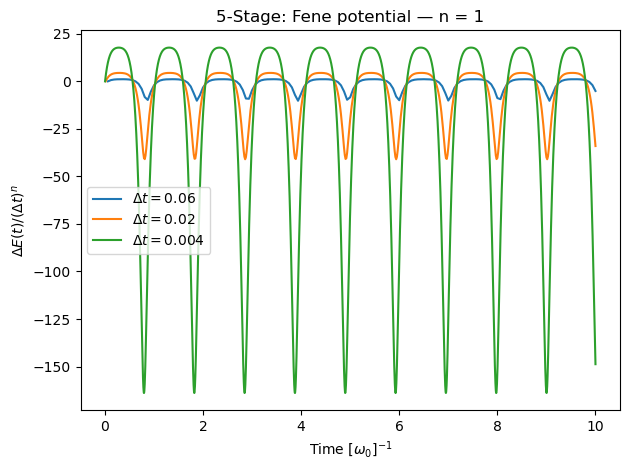

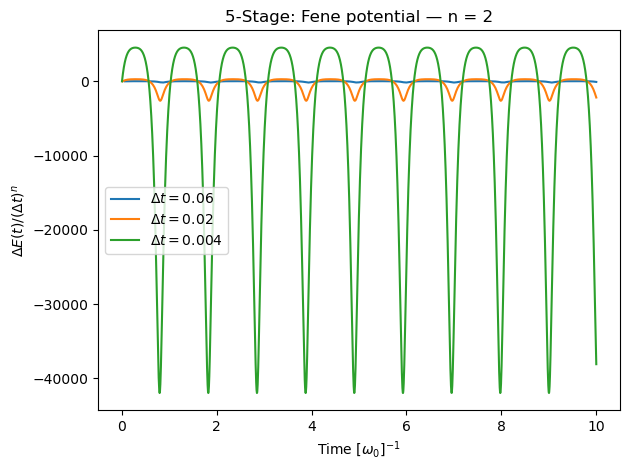

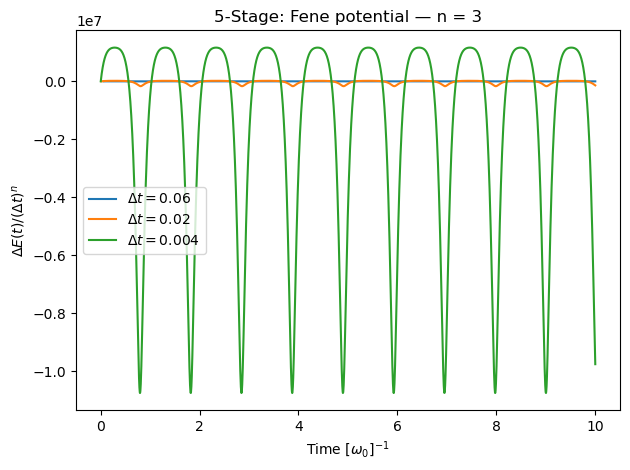

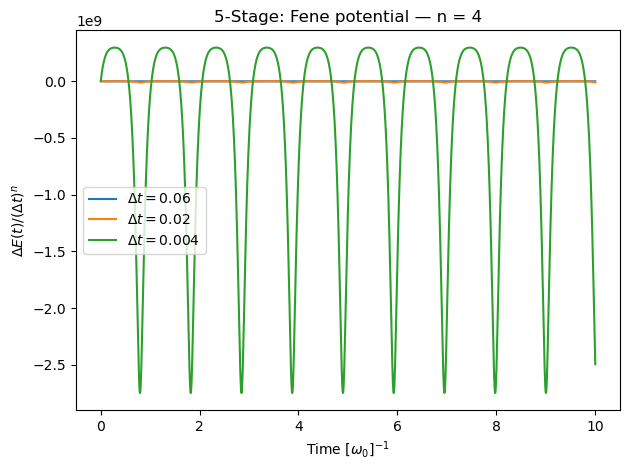

In [7]:
from integrators.omelyan_11stage import simulate_11stage

res_11 = simulate_11stage(dt=0.01, potential_type="harmonic")
plot_trajectory(res_11, title="11-Stage Integrator — Harmonic")
res_11_fene = simulate_11stage(dt=0.01, potential_type="fene")
plot_trajectory(res_11_fene, title="11-Stage Integrator — Fene")


omega_0_inv = 1.0
dts = [4**(-i) * omega_0_inv for i in range(1, 5)]
orders = [1, 2, 3, 4]

for potential in ["harmonic", "fene"]:
    energy_data = {}
    
    dts_filtered = dts if potential == 'harmonic' else dts[1:]  # removing larger timestep in the case of anharmonic potential
    for dt in dts_filtered:
        res = simulate_11stage(dt=dt, potential_type=potential)
        energy_data[dt] = (res["time"], res["E_traj"])

    plot_scaled_energy(dts, energy_data, orders, title=f"5-Stage: {potential.title()} potential")